# **Logistic Regression**
## **Introduction**

### Now that we know about linear regressions, let's explore another powerful technique: logistic regression. While both share the word "regression," they serve different purposes in the modeling world. We'll uncover these distinctions and more as we proceed.

### In the previous notebook on linear regression, we aimed to predict a continuous outcome variable. However, there are many real-world scenarios where the outcome isn't continuous but categorical, specifically binary (e.g., Yes or No, Positive or Negative, 1 or 0). Enter logistic regression, the go-to method for binary classification tasks.

### Unlike linear regression, where the outcome is continuous, logistic regression deals with probabilities. Specifically, it estimates the probability that a given input point belongs to a certain category. At its core, logistic regression is about drawing a boundary (decision boundary) that best separates the two categories based on the input features.

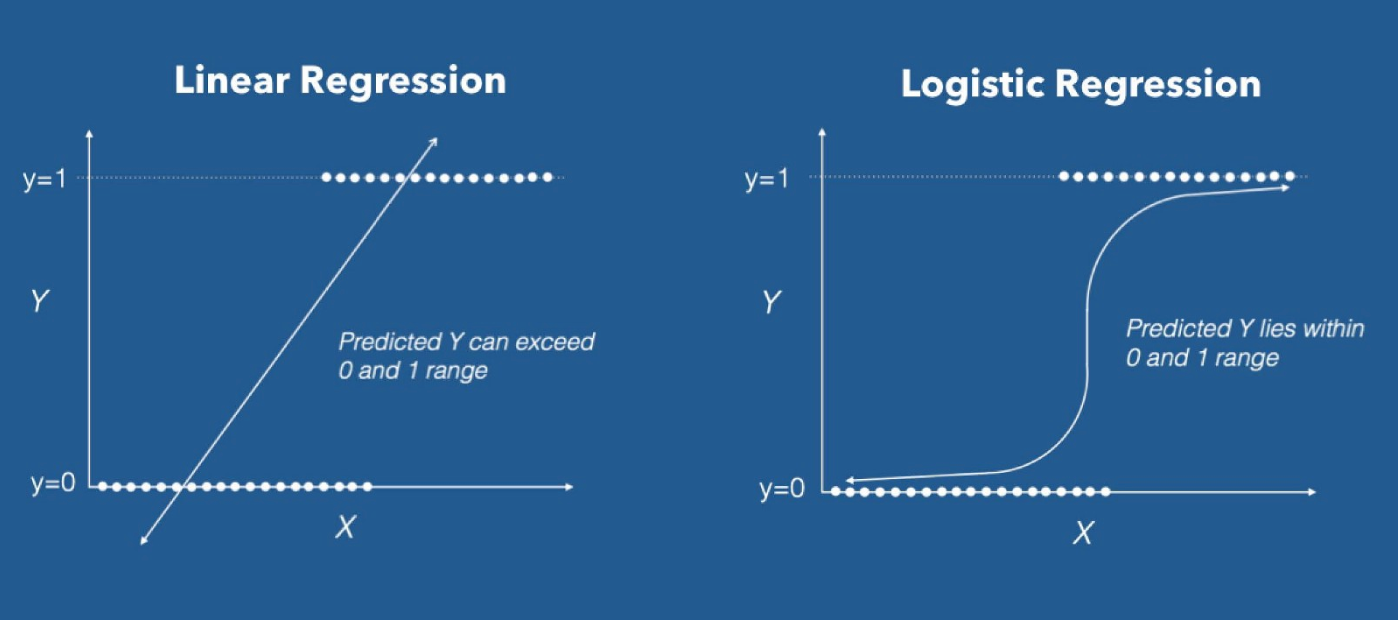


### However, a logistic regression model is still a model, so we follow the same train, test, deploy pipeline as we talked about previously. The tool changes, the workflow does not


### Lets discuss some of the 'under the hood' operations of a logistic regression. While the linear regression equation might look familiar as $\hat{Y}=X\theta$, the logistic regression equation undergoes a transformation to handle probabilities represented by $\hat{y}$ = $\Sigma(\Theta^TX)$ = $\frac{1} {1 + e^-\Theta^Tx }$ . This transformation ensures that the output of the model lies between 0 and 1, representing probabilities. The function used here is the sigmoid or logistic function, which gives the logistic regression its name. 

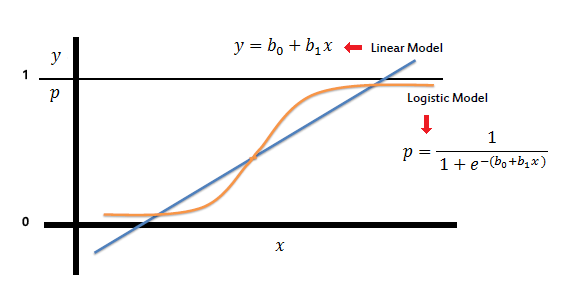

### Don't be confused by all the symbols! At its fundamental level, the logistic regression is providing an output between 0 or 1 in order to predict the category a certain input belongs to. In our case, based on the inputs we provide, we will predict whether or not the individual is at risk of heart failure (1) or not (0). 

### Evaluating a logistic regression model's performance is slightly different from linear regression:, and we will take a look at all of these in detail later on in the notebook, but we just want to introduce them now.

1. ### Accuracy: The proportion of total predictions that are completely correct. It's the ratio of the number of correct predictions to the total predictions.
2. ### Precision: Out of the samples predicted as positive, how many are actually positive?
3. ### Recall (Sensitivity): Out of the actual positives, how many are predicted as positive?
4. ### AUC-ROC Curve: A graphical representation showing the performance of a classification model at all classification thresholds. The closer the curve is to the top-left corner, the better the model's performance.

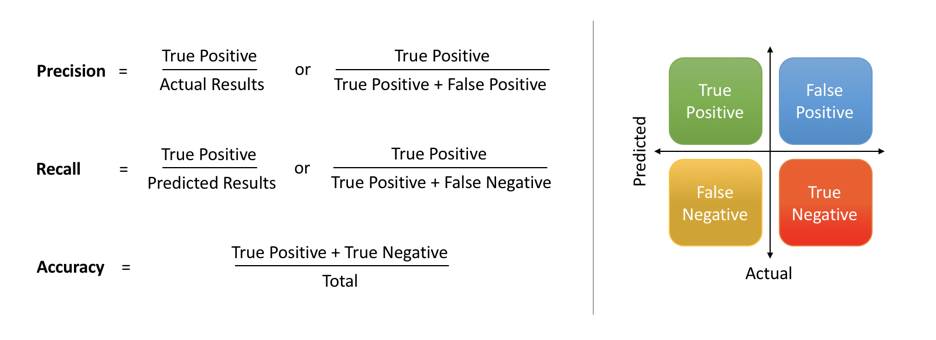

## **Import Stuff**

In [34]:
%pip install seaborn
%pip install statsmodels

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  confusion_matrix, roc_auc_score
from sklearn.feature_selection import RFE


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Same data preparation code as in the other notebooks. You can skip this- we are just applying the same cleaning and preprocessing we did before in this notebook to get the data in the cleaned state.

In [35]:
df = pd.read_csv('heart_disease.csv')

df.dropna(inplace=True)

categorical_columns = ['Gender', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'Heart_stroke']

for column in categorical_columns:
    df[column] = df[column].astype('category')
        
text_columns = ['Gender', 'education', 'prevalentStroke', 'Heart_stroke']

for column in text_columns: 
    df[column] = df[column].str.lower()
    
df['prevalentStroke'] = df['prevalentStroke'].map({'yes': 1, 'no': 0})
df['Heart_stroke'] = df['Heart_stroke'].map({'yes': 1, 'no': 0})
df['Gender'] = df['Gender'].map({'male': 0, 'female': 1})
df['education'] = df['education'].map({'uneducated': 0, 'primaryschool': 1, 'graduate':2, 'postgraduate':3})

### In the upcoming code block, we've defined a function doRegression to perform logistic regression and evaluate its performance. As there are more lines of code to run the logisic regression and we will be doing it a few times it is easier to just make a function we can reuse.

### The procedure is very similar to what you saw in the linear regression notebook. We will:
1. ###  Split the dataset (80/20 train/test) 
2. ### Initialize the model using `LogisticRegression()` from `sklearn` which we imported earlier
3. ### Fit the model using our training data
4. ### Make predictions using our x test data (in this case our predictions are binary as it is a logistic regression)
5. ### Evaluate the model: We'll be using several metrics to understand our model's performance which will be returned from this function

- ### Confusion Matrix: A table showcasing true positives, true negatives, false positives, and false negatives.
- ### Classification Report: Contains key metrics such as precision, recall, and the F1-score.
- ### ROC-AUC Score: Represents the model's ability to distinguish between the positive and negative classes.


In [36]:
# Import the necessary metrics for evaluation
from sklearn.metrics import classification_report

# Define a function 'doRegression' to perform logistic regression
# The function accepts predictor variables 'x' and the outcome variable 'y'
def doRegression(x,y):
    # Split the data into training and testing sets using a 80-20 split
    # The 'random_state' parameter is set to 42 for reproducibility
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Instantiate a Logistic Regression model
    # Logistic Regression is a statistical model used to model a binary outcome variable based on one or more predictor variables
    log_model = LogisticRegression()
    
    # Fit the model to the training data
    # The model 'learns' the relationship between the predictor(s) and the outcome
    log_model.fit(X_train, y_train)
    
    # Use the model to predict outcomes for the test set
    y_pred = log_model.predict(X_test)

    # Create a confusion matrix from the actual and predicted outcomes
    # A confusion matrix is a table that is used to evaluate the performance of a classification model. We will discuss this in detail later
    # Its not that confusing we promise!
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Calculate predicted probabilities for the positive class
    # These probabilities provide insight into the confidence of the predictions
    # Need this for ROC-AUC (another metric we will talk about in detail later)
    y_pred_proba = log_model.predict_proba(X_test)[:,1]

    # Compute the Area Under the Receiver Operating Characteristic Curve (ROC-AUC) from prediction scores
    # ROC-AUC is a popular metric for evaluating classifier performance
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Return a classification report (precision, recall, f1-score, support), confusion matrix and ROC-AUC score
    return classification_report(y_test, y_pred), conf_matrix, roc_auc


### Now lets set up an initial logistic regression. For this we will be starting small and just using a single predictor (cigarettes smoked per day in this case). We will use cigarettes smoked per day to try and predict whether or not the individual will develop heart stroke

### We will move on to some more complex analyses in a bit, but this is just to get our feet wet



In [45]:
# Define the predictor (what we believe could help us predict whether a heart stroke might happen) and target variables for the analysis
x = df[['cigsPerDay']]  # predictor: 'cigsPerDay' column from the dataframe df

y = df['Heart_stroke']  # target variable (what we are interested in predicting): 'Heart_stroke' column from the dataframe df

# Call the previously defined 'doRegression' function, passing the predictor and target variables as parameters
# This function will train a logistic regression model using the given predictor and target variables, 
# and it will return a classification report (precision, recall, f1-score, support), a confusion matrix, and the ROC-AUC score.
# See the function for details 
classification_report_output, conf_matrix, roc_auc = doRegression(x,y)


# Print the classification report, confusion matrix, and ROC-AUC score

# The classification report includes metrics such as:
# precision (true positives divided by all positives), 
# recall (true positives divided by the number of true positives plus the number of false negatives)
# F1 score (a weighted average of precision and recall).
print(classification_report_output)

# The confusion matrix provides a visual look at the performance of the model by showing the true positives, 
# true negatives, false positives, and false negatives.
print(conf_matrix)

# The ROC-AUC score represents the model's ability to distinguish between the positive and negative classes. 
# It ranges from 0.5 to 1, where 0.5 indicates a model that performs no better than random chance, and 1 indicates a perfect model.

print(roc_auc)


              precision    recall  f1-score   support

           0       0.83      1.00      0.91       610
           1       0.00      0.00      0.00       122

    accuracy                           0.83       732
   macro avg       0.42      0.50      0.45       732
weighted avg       0.69      0.83      0.76       732

[[610   0]
 [122   0]]
0.5112738511152916


/Users/georgienahass/opt/anaconda3/envs/mnist/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/georgienahass/opt/anaconda3/envs/mnist/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/georgienahass/opt/anaconda3/envs/mnist/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

### Try doing it with 2 variables now to see if that increaseS AUC

In [39]:
# Define predictor and target variables
x = df[['BPMeds','prevalentHyp']]  # predictor
y = df['Heart_stroke']  # target variable (what we are interested in predicting): 'Heart_stroke' column from the dataframe df

classification_report_output, conf_matrix, roc_auc = doRegression(x,y) # Do regression 

# Print outputs

print(classification_report_output)
print(conf_matrix)
print(roc_auc)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       610
           1       0.00      0.00      0.00       122

    accuracy                           0.83       732
   macro avg       0.42      0.50      0.45       732
weighted avg       0.69      0.83      0.76       732

[[610   0]
 [122   0]]
0.6289035205589895


/Users/georgienahass/opt/anaconda3/envs/mnist/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/georgienahass/opt/anaconda3/envs/mnist/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/georgienahass/opt/anaconda3/envs/mnist/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

### Didnt really go up that much. Bummer. Should we try and force every combination of column data we can to increase our predictor? We could, OR we could use a machine learning tool called recusive feature elimination (RFE).

### We will initially train the model with every feature (variable), and then gradually drop out the least important ones until we have distilled down the most important ones (we can set the number of how many features we want left). In Python, a lot of this happens under the hood so you will mostly just see the syntax, but this is a process called *feature engineering*. There are tons of ways to do this, and the *right* way depends on the specific data you are using coupled with your own domain knowledge. RFE is not right in every case, but we use it here because it is easy to understand and a great introduction to feature engineering!

### Make function for log regression with recursive feature elimination

In [40]:
from sklearn.metrics import classification_report

# This function performs Logistic Regression with Recursive Feature Elimination (RFE) to select the top 5 most relevant features
def doRegressionWithRFE(x,y):
    
    # Split the input data into training and testing datasets, with 80% of data used for training and 20% used for testing
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Initialize the Logistic Regression model
    log_model = LogisticRegression()

    # Initialize RFE with the logistic regression model and specify to select top 7 features
    selector = RFE(log_model, n_features_to_select=7, step=1)

    # Fit the RFE selector on the training data
    selector = selector.fit(X_train, y_train)

    # Print the features selected by RFE. This is achieved by creating a series combining feature names and their selection status, then printing those selected.
    selected_features = pd.Series(selector.support_, index=X_train.columns)
    print(selected_features[selected_features==True])

    # Transform the training and test data sets so only the selected features remain
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    # Fit the Logistic Regression model on the selected features of the training data
    log_model.fit(X_train_selected, y_train)

    # Predict the outcomes for the test set
    y_pred = log_model.predict(X_test_selected)

    # Print the confusion matrix, which gives a summary of the prediction results on the test data
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Compute the predicted probabilities for the positive class
    y_pred_proba = log_model.predict_proba(X_test_selected)[:,1]

    # Print the model's accuracy on the test set
    print('score', log_model.score(X_test_selected,y_test))

    # Compute ROC-AUC score, which quantifies the model's ability to distinguish between classes
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Return a detailed classification report, the confusion matrix, and the ROC-AUC score
    return classification_report(y_test, y_pred), conf_matrix, roc_auc


### Do log regression using feature selection and one hot encodings

In [41]:
# Convert categorical variables in the dataset into indicator (or dummy) variables. Each unique value in the original column is
# expanded into a new column that takes binary values (0, 1)
#  gender   -->one hot encoding --> gender_male  gender_female
#0   male                               1              0
#1 female                               0              1
#2   male                               1              0
#3 female                               0              1
df_encoded = pd.get_dummies(df)

# Call the function to perform Logistic Regression with RFE
# For predictors (x), we use all columns in the dataframe after converting categorical variables to dummy variables, except the target column 
# 'Heart_stroke'. We didn't do this before because some categorical variable's weren't appropriate for the regression. We have fixed that now by using one hot encoding
x = df_encoded.drop(columns=['Heart_stroke'])

# The target variable (y) is 'Heart_stroke'
y = df_encoded['Heart_stroke']

# Call the function defined previously, passing in the predictor variables and the target variable
# The function returns a classification report, a confusion matrix, and the ROC-AUC score
classification_report_output, conf_matrix, roc_auc = doRegressionWithRFE(x,y)

# Print the results
print(classification_report_output)
print(conf_matrix)
print(roc_auc)


/Users/georgienahass/opt/anaconda3/envs/mnist/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/georgienahass/opt/anaconda3/envs/mnist/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Gender             True
prevalentStroke    True
BPMeds_1.0         True
prevalentHyp_0     True
prevalentHyp_1     True
diabetes_0         True
diabetes_1         True
dtype: bool
score 0.8319672131147541
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       610
           1       0.40      0.02      0.03       122

    accuracy                           0.83       732
   macro avg       0.62      0.51      0.47       732
weighted avg       0.76      0.83      0.76       732

[[607   3]
 [120   2]]
0.6435232464391293


Precision is the number of true positive results divided by the number of all positive results, including those not identified correctly, and the high precision relates to the low false positive rate. For instance, the precision for the '0' class is 0.83, meaning that 83% of the instances that were predicted as '0' were actually '0'.

Recall (Sensitivity) - the number of true positive results divided by the number of all samples that should have been identified as positive. For instance, the recall for the '0' class is 1.00, meaning that all the instances of '0' were identified correctly.

The F1-score is the harmonic mean of precision and sensitivity. It tries to find the balance between precision and recall. It is most useful in uneven class distribution problems as it seeks a balance between Precision and Recall in an unbalanced dataset.

The support is the number of occurrences of the given class in your dataset (e.g., there are 610 instances of '0' and 122 instances of '1').

The accuracy of the model is 0.83, meaning that it correctly predicted the outcome 83% of the time for your test set.

The Recursive Feature Elimination (RFE) algorithm works by fitting the model, evaluating its performance, and then recursively removing the least important features until the desired number of features is left. The criterion for "importance" depends on the specific model used. For instance, in the case of logistic regression, it's the absolute values of the coefficients.

However, feature selection doesn't always lead to better performance. It is fundamentally a search problem in the space of feature subsets, and there's no guarantee that the search strategy of RFE (or any other feature selection algorithm) will find the optimal subset for your specific model and dataset.

Here are a few reasons why your precision did not increase after using RFE:

Model Bias: The RFE algorithm relies on the model for estimating feature importance. If the model has any bias towards certain types of features, RFE might not be able to select the best feature set.

Interactions Among Features: RFE, in its simplest form, assumes that features contribute to the model independently of each other. If there are important interactions among features, RFE might miss them.

Overfitting or Underfitting: Selecting fewer features can lead to underfitting if the model becomes too simple to capture the underlying structure of the data. On the other hand, selecting too many features can lead to overfitting, especially if some of the features are noisy or irrelevant.